## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [0]:
import torch
import torch.nn as nn
from torch.autograd.function import Function

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss


class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None


## Import modules

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

print("Pytorch version:  " + str(torch.__version__))

use_cuda = torch.cuda.is_available()

print("Use CUDA: " + str(use_cuda))

Pytorch version:  0.4.1
Use CUDA: True


In [0]:
BATCH_SIZE = 64
BATCH_SIZE_TEST = 1000
EPOCHS = 50
LOG_INTERVAL = 10
NUM_OF_CLASSES = 10

## Dataset setup

In [0]:
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True, **kwargs)

## Model setup

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        krnl_sz=3
        strd = 1
                    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)

        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))

        self.fc1 = nn.Linear(3*3*512, 3)
#         self.fc2 = nn.Linear(3, 2)
        self.fc3 = nn.Linear(3, 10)

    def forward(self, x):
        mp_ks=2
        mp_strd=2

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = x.view(-1, 3*3*512) # Flatten

        features3d = self.fc1(x)
#         features2d = self.fc2(features3d)
        x = F.prelu(features3d, self.prelu_weight)

        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1), features3d


In [7]:
model = Net()
model.eval()
# model.cuda()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=10, bias=True)
)

In [0]:
### MODEL TEST RUN
# ind = 12
# image_tensor, label_tensor = test_loader.dataset[ind]
# image_tensor = image_tensor.reshape(1,1,28,28)
# image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

# prediction, features3d, features2d = model(image_tensor)
# prediction = np.argmax(prediction.detach().numpy())
# print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

# print("features3d:  " + str(features3d.detach().numpy()))
# print("features2d:  " + str(features2d.detach().numpy()))


## Train setup

In [0]:
def centerLoss(pred, target, device, features3d):
  # NLLLoss
  nllloss = nn.NLLLoss().to(device) #CrossEntropyLoss = log_softmax + NLLLoss
  
  # CenterLoss
  loss_weight = 1
  centerloss = CenterLoss(NUM_OF_CLASSES , 3).to(device) # 3 num of features
  return nllloss(pred, target) + loss_weight * centerloss(target, features3d)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        pred, features3d = model(data)
#         loss = F.nll_loss(pred, target)
        loss = centerLoss(pred, target, device, features3d)
  
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,features3d = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            
            test_loss += centerLoss(output, target, device, features3d)

            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
  
#     bp()
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

    print('\nTest set: Average loss: {}, Accuracy: {}/{} ({}%)\n'.format(
        str(test_loss), str(correct), str(len(test_loader.dataset)),
        str(100. * correct / len(test_loader.dataset))))

## Train process

In [10]:
from pdb import set_trace as bp

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(),"mnist_cnn-center-loss.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 3.821239
Train Epoch: 1 [640/60000 (1%)]	Loss: 3.794778
Train Epoch: 1 [1280/60000 (2%)]	Loss: 3.869755
Train Epoch: 1 [1920/60000 (3%)]	Loss: 4.348871
Train Epoch: 1 [2560/60000 (4%)]	Loss: 4.066046
Train Epoch: 1 [3200/60000 (5%)]	Loss: 4.057664
Train Epoch: 1 [3840/60000 (6%)]	Loss: 3.715936
Train Epoch: 1 [4480/60000 (7%)]	Loss: 3.543021
Train Epoch: 1 [5120/60000 (9%)]	Loss: 3.513697
Train Epoch: 1 [5760/60000 (10%)]	Loss: 4.249573
Train Epoch: 1 [6400/60000 (11%)]	Loss: 4.455543
Train Epoch: 1 [7040/60000 (12%)]	Loss: 4.036344
Train Epoch: 1 [7680/60000 (13%)]	Loss: 4.199635
Train Epoch: 1 [8320/60000 (14%)]	Loss: 3.674611
Train Epoch: 1 [8960/60000 (15%)]	Loss: 3.190120
Train Epoch: 1 [9600/60000 (16%)]	Loss: 3.865029
Train Epoch: 1 [10240/60000 (17%)]	Loss: 4.036717
Train Epoch: 1 [10880/60000 (18%)]	Loss: 4.268999
Train Epoch: 1 [11520/60000 (19%)]	Loss: 4.079448
Train Epoch: 1 [12160/60000 (20%)]	Loss: 3.979766
Train Epoch: 1 [12800/60000 (

In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn-center-loss.pt') 


## Load Model

In [11]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn-center-loss.pt", map_location='cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=10, bias=True)
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 0
features3d:  [[-0.43270937 -0.5319073   0.09278587]]


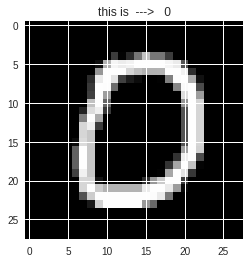

In [16]:
ind = 10

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

prediction, features3d = model(image_tensor)
prediction = np.argmax(prediction.cpu().detach().numpy())
print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

print("features3d:  " + str(features3d.cpu().detach().numpy()))
# print("features2d:  " + str(features2d.cpu().detach().numpy()))


-----------

In [0]:
# Visualize train_data

In [47]:
f3d_train = []
lbls_train = []

for i in range(10000):
    image_tensor_train, label_tensor_train = train_loader.dataset[i]
    image_tensor_train = image_tensor_train.reshape(1,1,28,28)
    image_tensor_train, label_tensor_train = image_tensor_train.to(device), label_tensor_train.to(device)

    prediction_train, features3d_train = model(image_tensor_train)
    f3d_train.append(features3d_train[0].cpu().detach().numpy())

    prediction_train = np.argmax(prediction_train.cpu().detach().numpy())    
    lbls_train.append(prediction_train)

    
    
feat3d_train = np.array(f3d_train)
print("3d features train shape" + str(feat3d_train.shape))
lbls_train = np.array(lbls_train)
print("labels train shape" + str(lbls_train.shape))


3d features train shape(10000, 3)
labels train shape(10000,)


In [49]:
f3d_test = []
lbls_test = []

for i in range(10000):
    image_tensor_test, label_tensor_test = test_loader.dataset[i]
    image_tensor_test = image_tensor_test.reshape(1,1,28,28)
    image_tensor_test, label_tensor_test = image_tensor_test.to(device), label_tensor_test.to(device)

    prediction_test, features3d_test = model(image_tensor_test)
    f3d_test.append(features3d_test[0].cpu().detach().numpy())

    prediction_test = np.argmax(prediction_test.cpu().detach().numpy())    
    lbls_test.append(prediction_test)

    
    
feat3d_test = np.array(f3d_test)
print("3d features test shape" + str(feat3d_test.shape))
lbls_test = np.array(lbls_test)
print("labels test shape" + str(lbls_test.shape))


3d features test shape(10000, 3)
labels test shape(10000,)


# Visualize 2d

In [0]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# f = plt.figure(figsize=(16,9))
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# for i in range(10):
#     plt.plot(feat2d[lbls==i,0].flatten(), feat2d[lbls==i,1].flatten(), '.', c=c[i])
# plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# plt.grid()
# plt.show()

# Visualize Train Data 3d

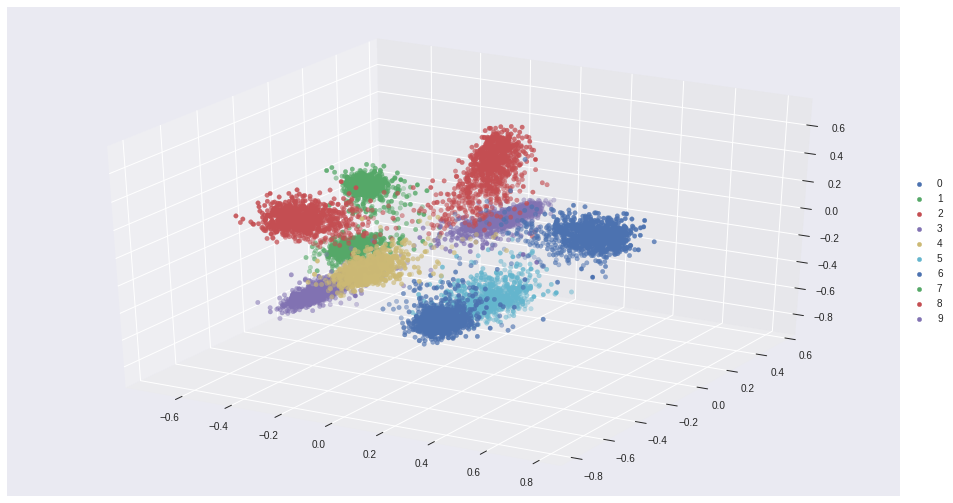

In [48]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d_train[lbls_train==i,2].flatten()
    ydata = feat3d_train[lbls_train==i,0].flatten()
    zdata = feat3d_train[lbls_train==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Visualize Test Data 3d

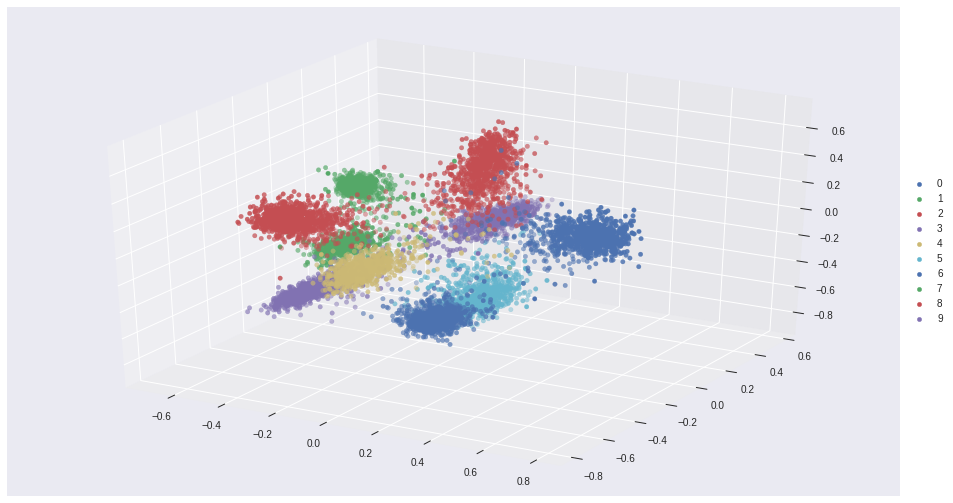

In [50]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d_test[lbls_test==i,2].flatten()
    ydata = feat3d_test[lbls_test==i,0].flatten()
    zdata = feat3d_test[lbls_test==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()